In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import pyemma
import mdtraj
import pyemma.util.contexts
import pickle
from pathos.multiprocessing import Pool
from contextlib import closing
import seaborn as sns

## Estimation

In [2]:
# load data from disk
topfile_0cal = 'hsynapto.pdb'
trajfiles_aligned = np.loadtxt('trajfile_list.txt', dtype=str).tolist()

# reference mdtraj trajectory object
ref_0cal = mdtraj.load_pdb(topfile_0cal)

In [233]:
first_resid = 5  # truncate n and c-terminal residues
system_integers = np.arange(first_resid, ref_0cal.top.n_residues - first_resid)

In [236]:
# compute feature vector for each residue and store in a dictionary
# ATTENTION: the features should be carefully chosen, this example reproduces 
# a featurization that was previously published and might not be optimal for
# other cases. Cf. Chignolin notebook for flexible torsion angle featurization.

res_heavyatomxyzs = dict()

with pyemma.util.contexts.settings(show_progress_bars=False):
    for n in tqdm(system_integers):
        f = pyemma.coordinates.featurizer(topfile_0cal)
        f.add_selection(f.select(f'mass > 2 and resid {n}'))
        res_heavyatomxyzs[n] = pyemma.coordinates.load(trajfiles_aligned, features=f)

<ipython-input-236-8899c88b1cea>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm(system_integers):


  0%|          | 0/118 [00:00<?, ?it/s]

In [237]:
# save or load from disc to increase efficiency
# pickle.dump(res_heavyatomxyzs, open('res_heavyatomxyz.pickle', 'wb'))
# res_heavyatomxyzs = pickle.load(open('res_heavyatomxyz.pickle', 'rb'))

In [238]:
# choose lag time for vamp computation (in ns)
msmlag = 50

In [239]:
# all pairwise combinations of residue indices
args = list(itertools.combinations(system_integers, 2))

def get_edge_vamp2(n1, n2, stride=1):
    """
    Compute normalized dependency between two feature
    vectors using the VAMP2 score.
    
    :params:
    :n1: int, residue index of residue A
    :n2: int, residue index of residue B
    :stride: int, optional, used in covariance matrix estimation
    
    :returns:
    float, dependency for this link
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        v1 = pyemma.coordinates.vamp(feature[n1], lag=msmlag, stride=stride)
        v2 = pyemma.coordinates.vamp(feature[n2], lag=msmlag, stride=stride)
        v12 = pyemma.coordinates.vamp([np.hstack([t1, t2]) for t1, t2 in zip(feature[n1], feature[n2])], lag=msmlag, stride=stride)

    s1 = v1.score(score_method='VAMP2')
    s2 = v2.score(score_method='VAMP2')
    s12 = v12.score(score_method='VAMP2')
    
    # note that pyemma returns the vamp score in the non-whitened space (+1)
    # i.e. we have to subtract 1 from each computed score
    d =  (s1 + s2 - 1 - s12) / min(s1 - 1, s2 - 1)
        
    return d

def get_edge_vamp1(n1, n2, stride=1):
    """
    Compute normalized dependency between two feature
    vectors using the VAMP1 score.
    
    :params:
    :n1: int, residue index of residue A
    :n2: int, residue index of residue B
    :stride: int, optional, used in covariance matrix estimation
    
    :returns:
    float, dependency for this link
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        v1 = pyemma.coordinates.vamp(feature[n1], lag=msmlag, stride=stride)
        v2 = pyemma.coordinates.vamp(feature[n2], lag=msmlag, stride=stride)
        v12 = pyemma.coordinates.vamp([np.hstack([t1, t2]) for t1, t2 in zip(feature[n1], feature[n2])], lag=msmlag, stride=stride)

        s1 = v1.score(score_method='VAMP1')
        s2 = v2.score(score_method='VAMP1')
        s12 = v12.score(score_method='VAMP1')
        
        d =  (s1 + s2 - 1 - s12) / min(s1 - 1, s2 - 1)
        
    return d

In [ ]:
feature = res_heavyatomxyzs

In [240]:
# VAMP-1 graph
# initialize networkx graph object
graph_vamp1 = nx.Graph()


# multiprocessing w/ progress bar
pbar = tqdm(total=len(args))
pool = Pool(processes=8)
with closing(pool):
    # compute pairwise dependency on each pair of residues, populate graph edges
    res_async = [pool.apply_async(get_edge_vamp1, a, callback=lambda _: pbar.update(1)) for a in args]
    [graph_vamp1.add_edge(*a, weight=x.get()) for x, a in zip(res_async, args)]
    
pbar.close()

<ipython-input-240-723c12f03652>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=len(args))


  0%|          | 0/6903 [00:00<?, ?it/s]

In [241]:
# VAMP-2 graph
# initialize networkx graph object
graph_vamp2 = nx.Graph()

# multiprocessing w/ progress bar
pbar = tqdm(total=len(args))
pool = Pool(processes=8)
with closing(pool):
    # compute pairwise dependency on each pair of residues, populate graph edges
    res_async = [pool.apply_async(get_edge_vamp2, a, callback=lambda _: pbar.update(1)) for a in args]
    [graph_vamp2.add_edge(*a, weight=x.get()) for x, a in zip(res_async, args)]
    
pbar.close()

<ipython-input-241-a0aea468303d>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=len(args))


  0%|          | 0/6903 [00:00<?, ?it/s]

In [242]:
# save or re-load graphs
# pickle.dump(graph_vamp1, open('syt_graph_vamp1.pickle', 'wb'))
# graph_vamp1 = pickle.load(open('syt_graph_vamp1.pickle', 'rb'))

# pickle.dump(graph_vamp2, open('syt_graph_vamp2.pickle', 'wb'))
# graph_vamp2 = pickle.load(open('syt_graph_vamp2.pickle', 'rb'))

## Visualization

In [550]:
# set node sizes and edge widths
nodesize = 20
edgewidth = 1

# define color for edges
# color map scale adjusted individually
_c = (0., 0., 0.)

In [245]:
# Fruchterman-Reingold (FR) node positioning
# please note that FR is stochastic and results might be slightly different
# for each execution

ks = [.01, 0.012] # FR hyperparameter

pos_dicts = []
frugold_projections = []
for n, graph in enumerate([graph_vamp1, graph_vamp2]):

    # use networkx implementation of FR algorithm
    pos_dict = nx.spring_layout(graph, k=ks[n], 
                                iterations=5000, threshold=0.00001)
    pos_dicts.append(pos_dict)
    frugold_projections.append(np.array([pos_dict[r] for r in system_integers]))

In [499]:
# color definitions
sns_pal = sns.color_palette('hls', 3)  # highlight important subunits
sns_pal2 = sns.color_palette('bone_r', 6)  # grey palette for less important subunits
vmd_colors = np.vstack([np.array(sns_pal), np.array(sns_pal2)])
col_pal = ['#80aee7ff', '#e68082ff']  # for histograms

In [479]:
# cluster FR projected data with k-means
# remember that k-means is stochastic and might produce slightly different 
# results each for each run. this step further depends on the result of
# the FR algorithm, i.e., it might be necessary to adjust hyperparameters

n_clusters = [7, 7] # number of nodes for vamp-1 / vamp-2 projections

assignments = []
cluster_objs = []

for n, (k, xy) in enumerate(zip(n_clusters, frugold_projections)):
    # cluster in projected space
    cl = pyemma.coordinates.cluster_kmeans(xy, k=k, tolerance=1e-7, 
                                           max_iter=100)
    cluster_objs.append(cl)
    assignments.append(cl.dtrajs[0])

initialize kmeans++ centers:   0%|          | 0/7 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/7 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [553]:
# color-matching. numbers have no physical meaning
# and are manually sorted for readability.
# assignment from VMD visual inspection.

cassignm = [np.array([6, 3, 2, 0, 4, 1, 5]),
                  np.array([4, 3, 1, 5, 0, 6, 7])]

matched_assignments = []
for n in range(len(assignments)):
    matched_assignments.append(cassignm[n][assignments[n]])

In [556]:
# to quantify the differences between a) dependencies of
# nodes in a cluster and b) dependencies between nodes of different clusters, 
# each node has to be viewed from its strongest embedding into the network. 
# 
# Example: network consisting of 3 nodes [n1, n2, n3]. If dependency scores 
# between (n1, n2) and (n2, n3) are very high, the network cannot be decomposed
# irrespectively of how low the dependency is for (n1, n3).
    
# This means that the dependency between a single node n and a set of nodes C
# should be viewed by taking the max of all edges between n and all nodes of C. 

intra_cluster_edge_list, inter_cluster_edge_list = [], []
for assignments, graph, _n_clusters in zip(matched_assignments, 
                                           [graph_vamp1, graph_vamp2], 
                                          n_clusters):
        
    # group cluster nodes together
    node_groups = [np.array(list(graph.nodes))[np.where(assignments == n)[0]] \
                   for n in np.unique(assignments)]

    # extract edges within each cluster and between two clusters
    inter_cluster_edges = []
    intra_cluster_edges = []
    
    # iterate over all combinations of clusters
    # -> extract inter-cluster edges
    for cluster_i, cluster_j in itertools.combinations(range(_n_clusters), 2):
        
        _inter_cluster_edges = []

        # max link between (each member of cluster i) and (all members of cluster j)
        for node_i in node_groups[cluster_i]:
            w_to_all_cluster_j = [graph.get_edge_data(node_i, node_j)['weight'] for \
                                  node_j in node_groups[cluster_j]]
            _inter_cluster_edges.append(max(w_to_all_cluster_j))

        # max link between (each member of cluster j) and (all members of cluster i)
        for node_j in node_groups[cluster_j]:
            w_to_all_cluster_i = [graph.get_edge_data(node_i, node_j)['weight'] for \
                                  node_i in node_groups[cluster_i]]
            _inter_cluster_edges.append(max(w_to_all_cluster_i))
        
        inter_cluster_edges += _inter_cluster_edges

    # iterate over every cluster
    # -> extract intra-cluster edges
    for cluster_i in range(_n_clusters):
        
        _intra_cluster_edges = []
        
        # max link within a single cluster of nodes, i.e., get max edge between node and 
        # all other members of the same cluster
        for node_i in node_groups[cluster_i]:
            w_to_all_in_cluster = [graph.get_edge_data(node_i, node_j)['weight'] for \
                                   node_j in node_groups[cluster_i] if node_i!=node_j]
            _intra_cluster_edges.append(max(w_to_all_in_cluster))

        intra_cluster_edges += _intra_cluster_edges

    inter_cluster_edge_list.append(np.array(inter_cluster_edges))
    intra_cluster_edge_list.append(np.array(intra_cluster_edges))

In [506]:
def plot_dependency_graph(ax, _graph, pos_dict, assigments, edge_lcutoff=.3, nodelabels=False):
    """
    Plots the dependency graph using networkx and matplotlib.pyplot.
    :params:
    :ax: plt.Axes object, populated by this function
    :_graph: nx.Graph object, graph to show
    :pos_dict: dict, contains positions of graph nodes
    :assignments: list, assignment of colors (to match VMD output)
    :edge_lcutoff: float, cutoff value for edge weights; everything 
    below will not be shown
    :nodelabels: bool, optional, default: False. for matching clusters with VMD representation
    
    :returns:
    :ax: populated plt.Axes object
    :pc: matplotlib.collections.LineCollection of network edges
    """
    # remove invisible paths from graph (decreases SVG file size later)
    graph = nx.Graph()
    graph.add_nodes_from(_graph.nodes)
    for edge in _graph.edges():
        w = _graph.get_edge_data(*edge)['weight']
        if w > edge_lcutoff:
            graph.add_edge(*edge, weight=w)
    
    weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

    nx.draw_networkx_nodes(graph, 
                           node_size=nodesize,
                           pos=pos_dict, 
                           ax=ax, 
                           node_color=vmd_colors[assigments])
    
    if nodelabels:
        nx.draw_networkx_labels(graph, pos_dict, font_size=6)

    pc = nx.draw_networkx_edges(graph, 
                                edge_color=weights, 
                                width=edgewidth, 
                                pos=pos_dict, 
                                node_size=nodesize,
                                ax=ax, 
                                edge_cmap=edge_cmap, 
                                edge_vmax=1, 
                                edge_vmin=0
                               )
    
    return ax, pc

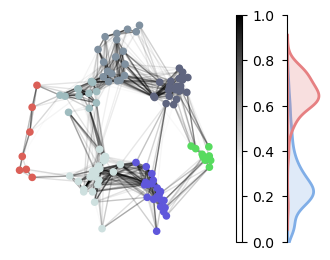

In [557]:
# VAMP 1
fig = plt.figure(figsize=(4, 3), dpi=100)
gs = fig.add_gridspec(65, 140)
fullax = fig.add_subplot(gs[:, :])
fullax.axis('off')

# network plot
ax = fig.add_subplot(gs[:, :95])
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", [(*_c, 0), (*_c, 0),
                                                                            (*_c, 0.5), (*_c, 1)])
ax, pc = plot_dependency_graph(ax, graph_vamp1, pos_dicts[0], matched_assignments[0])
ax.axis('off')

# colorbar
cbar_ax = fig.add_subplot(gs[:, 102:105])
cb = fig.colorbar(pc, cax=cbar_ax)

# histograms
ax = fig.add_subplot(gs[:, 125:])
sns.kdeplot(y=inter_cluster_edge_list[0], fill=True, ax=ax, color=col_pal[0], linewidth=2)
sns.kdeplot(y=intra_cluster_edge_list[0], fill=True, ax=ax, color=col_pal[1], linewidth=2)


ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlabel('')

# comment following line to verify that axes are matching
for loc in ['top', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_yticklabels([]);

fig.savefig('syt_vamp1.png', dpi=400)

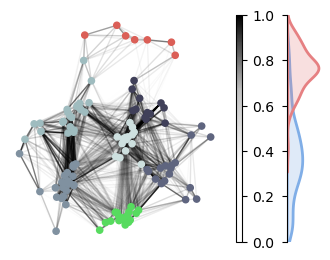

In [558]:
# VAMP 2
fig = plt.figure(figsize=(4, 3), dpi=100)
gs = fig.add_gridspec(65, 140)
fullax = fig.add_subplot(gs[:, :])
fullax.axis('off')

# network plot
ax = fig.add_subplot(gs[:, :95])

# tune down color-scale for visibility of nodes
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", [(*_c, 0), (*_c, 0),
                                                                            (*_c, 0.25), (*_c, 1)])
ax, pc = plot_dependency_graph(ax, graph_vamp2, pos_dicts[1], matched_assignments[1])
ax.axis('off')

# colorbar
cbar_ax = fig.add_subplot(gs[:, 102:105])
cb = fig.colorbar(pc, cax=cbar_ax)

# histograms
ax = fig.add_subplot(gs[:, 125:])
sns.kdeplot(y=inter_cluster_edge_list[1], fill=True, ax=ax, color=col_pal[0], linewidth=2)
sns.kdeplot(y=intra_cluster_edge_list[1], fill=True, ax=ax, color=col_pal[1], linewidth=2)


ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlabel('')

# comment following line to verify that axes are matching
for loc in ['top', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_yticklabels([]);

fig.savefig('syt_vamp2.png', dpi=400)

In [ ]:
# Please note that results are subject to stochasticity from Fruchterman-Reingold and k-means algorithms.

In [559]:
# resids for VMD figure coloring
for n, (assignm, nc) in enumerate(zip(matched_assignments, n_clusters)):
    print(f'####### VAMP {n+1} #####')
    for n in range(nc + 5):
        whe = np.where(assignm == n)[0]
        if len(whe) == 0:
            # some color assignments are unique to one of the graphs
            continue
        print(f'color #{n}:' + str(whe + first_resid))

####### VAMP 1 #####
color #0:[108 109 110 111 112 113 114]
color #1:[32 33 34 35 36 37 57 58 59 60 94]
color #2:[  5  22  23  24  25  26  27  28  29  30  31  61  62  63  64  65  66  67
  68  69 121]
color #3:[  6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  70  71
  73 115 116 117 118 119 120]
color #4:[ 72  74  75  76  77  78  79  80  81  82 106 107]
color #5:[ 44  45  46  47  48  49  50  51  52  53  83  84  85  86 102 103 104 105]
color #6:[ 38  39  40  41  42  43  54  55  56  87  88  89  90  91  92  93  95  96
  97  98  99 100 101 122]
####### VAMP 2 #####
color #0:[108 109 110 111 112 113 114]
color #1:[30 31 32 33 34 35 36 37 38 39 55 56 57 58 59 60 61 62 63]
color #3:[  5   6  12  13  14  15  16  17  18  25  73  75  93  94 119 121]
color #4:[ 46  47  48  49  50  76  77  78  79  80  81  82  83  95  96  97  98 103
 104 105 106 107 120]
color #5:[ 40  41  42  43  44  45  51  52  53  54  84  85  86  87  88  89  90  91
  92  99 100 101 102 122]
color #6:[20 21 22 23 2